In [160]:
import pandas as pd
import numpy as np
import dataframe_image as dfi
from IPython.display import display

def seconds_to_mmss(seconds):
    if pd.isna(seconds) or seconds < 0:
        return ''
    mins = int(seconds) // 60
    secs = int(seconds) % 60
    return f"{mins}:{secs:02d}"

# Load your datasets
match_metrics = pd.read_csv('report_match_metrics.csv')
events = pd.read_csv('report_event_metrics.csv')

# Merge attendance if not present
if 'event_attendance' not in match_metrics.columns:
    match_metrics = match_metrics.merge(
        events[['event_name', 'event_year', 'event_attendance']],
        on=['event_name', 'event_year'],
        how='left'
    )

# Count of distinct event years (i.e., events)
event_years = match_metrics['event_year'].dropna().astype(int).unique()
n_events = len(event_years)
first_year = int(min(event_years)) if n_events else ""

# Average attendance (mean unique event attendance over all events)
event_att = match_metrics.drop_duplicates(['event_name', 'event_year'])['event_attendance'].dropna().astype(float)
avg_att = int(round(event_att.mean())) if len(event_att) else ""

# Average number of matches per event (NO decimals)
match_counts = (
    match_metrics.groupby(['event_name', 'event_year'], dropna=False)['match_number'].count()
)
avg_match_count = int(round(match_counts.mean(), 0)) if len(match_counts) else ""

# Average match duration for all matches
avg_duration = int(round(match_metrics['match_duration_seconds'].dropna().mean())) if len(match_metrics) else ""

# Build single-row DataFrame
summary_row = [
    n_events,
    first_year,
    f"{avg_att:,}" if avg_att != "" else "",
    f"{avg_match_count:,}" if avg_match_count != "" else "",
    seconds_to_mmss(avg_duration)
]
cols = [
    "Events (Years)", "First Event Year",
    "Avg. Attendance", "Avg. Matches/Event", "Avg. Match Duration"
]
summary_df = pd.DataFrame([summary_row], columns=cols)

# --- Style and display/export ---
table_styles = [
    {
        "selector": "caption",
        "props": [
            ("caption-side", "top"),
            ("font-size", "15px"),
            ("color", "#fff"),
            ("font-weight", "bold"),
            ("text-align", "center"),
            ("padding", "10px 0 8px 0"),
        ],
    },
    {
        "selector": "th",
        "props": [
            ("background-color", "#DCECFB"),
            ("color", "#222"),
            ("text-align", "center"),
            ("font-weight", "bold"),
            ("font-size", "15px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
    {
        "selector": "td",
        "props": [
            ("text-align", "center"),
            ("font-size", "14px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
]
hide_index_style = [{"selector": ".row_heading, .blank", "props": [("display", "none")]}]

styled = (
    summary_df.style
    .set_table_styles(table_styles)
    .set_table_styles(hide_index_style, overwrite=False)
    .set_properties(**{'text-align': 'center', 'font-family': 'Helvetica, sans-serif'})
    .set_caption("Dataset Overview")
)

try:
    styled = styled.hide(axis="index")
except Exception:
    pass

display(styled)
dfi.export(styled, "dataset_overview.png", table_conversion="matplotlib", dpi=250)


Events (Years),First Event Year,Avg. Attendance,Avg. Matches/Event,Avg. Match Duration
37,1988,"22,658",8,11:46


In [166]:
import pandas as pd
import numpy as np
import dataframe_image as dfi
from IPython.display import display

def seconds_to_mmss(seconds):
    if pd.isna(seconds) or seconds < 0:
        return ''
    mins = int(seconds) // 60
    secs = int(seconds) % 60
    return f"{mins}:{secs:02d}"

# 1. Load data
match_metrics = pd.read_csv('report_match_metrics.csv')
events = pd.read_csv('report_event_metrics.csv')
results = pd.read_csv('report_result_metrics.csv')

needed_cols = ['event_name', 'event_year', 'event_attendance', 'event_venue', 'event_city', 'event_state', 'event_country']
if not all(col in match_metrics.columns for col in needed_cols):
    match_metrics = match_metrics.merge(
        events[needed_cols],
        on=['event_name', 'event_year'],
        how='left'
    )

cols = [
    'Event Year', 'Attendance', 'Location', 'Venue',
    'Main Event Winner', 'Main Event Loser', 'Match Duration'
]

def build_event_row(event, which):
    ey = event['event_year']
    try:
        ey_val = int(ey) if pd.notnull(ey) and ey != '' else ''
    except Exception:
        ey_val = ''
    attendance = event['event_attendance']
    attendance_str = f"{int(attendance):,}" if pd.notnull(attendance) and attendance != '' else ''

    location = ', '.join([
        str(x).strip() for x in [event.get('event_city'), event.get('event_state'), event.get('event_country')] 
        if pd.notnull(x) and str(x).strip()
    ])
    venue = event.get('event_venue', '') if pd.notnull(event.get('event_venue', '')) else ''

    # Find main event for this event (highest match_number)
    matches_in_event = match_metrics[(match_metrics['event_name'] == event['event_name']) & (match_metrics['event_year'] == event['event_year'])]
    if not matches_in_event.empty:
        main_event_row = matches_in_event.sort_values('match_number', ascending=False).iloc[0]
        match_num = main_event_row['match_number']
        is_year = results['event_year'] == ey
        is_name = results['event_name'] == event['event_name']
        is_match = results['match_number'] == match_num
        main_mask = is_year & is_name & is_match

        winners = results.loc[main_mask & (results['participant_role'].str.lower() == "winner"), 'wrestler_name'].tolist()
        losers = results.loc[main_mask & (results['participant_role'].str.lower() == "loser"), 'wrestler_name'].tolist()

        winner = ', '.join(winners) if winners else ''
        loser = ', '.join(losers) if losers else ''
        match_duration = seconds_to_mmss(main_event_row['match_duration_seconds']) if pd.notnull(main_event_row['match_duration_seconds']) else ''
    else:
        winner = loser = match_duration = ''

    return [
        ey_val, attendance_str, location, venue, winner, loser, match_duration
    ]

# Get event with largest attendance (skip events missing attendance)
events_clean = events[pd.notnull(events['event_attendance']) & (events['event_attendance'] != '')]
if not events_clean.empty:
    largest_idx = events_clean['event_attendance'].astype(float).idxmax()
    smallest_idx = events_clean['event_attendance'].astype(float).idxmin()
    largest_event = events_clean.loc[largest_idx]
    smallest_event = events_clean.loc[smallest_idx]
    largest_row = build_event_row(largest_event, "Largest")
    smallest_row = build_event_row(smallest_event, "Smallest")
    largest_df = pd.DataFrame([largest_row], columns=cols)
    smallest_df = pd.DataFrame([smallest_row], columns=cols)
else:
    largest_df = pd.DataFrame([['']*len(cols)], columns=cols)
    smallest_df = pd.DataFrame([['']*len(cols)], columns=cols)

# --- Style ---
def style_and_show(df, caption, fname):
    table_styles = [
        {
            "selector": "caption",
            "props": [
                ("caption-side", "top"),
                ("font-size", "15px"),
                ("color", "#fff"),
                ("font-weight", "bold"),
                ("text-align", "center"),
                ("padding", "10px 0 8px 0"),
            ],
        },
        {
            "selector": "th",
            "props": [
                ("background-color", "#DCECFB"),
                ("color", "#222"),
                ("text-align", "center"),
                ("font-weight", "bold"),
                ("font-size", "15px"),
                ("white-space", "nowrap"),
                ("padding", "10px 12px"),
                ("border", "1px solid #ddd"),
            ],
        },
        {
            "selector": "td",
            "props": [
                ("text-align", "center"),
                ("font-size", "14px"),
                ("white-space", "nowrap"),
                ("padding", "10px 12px"),
                ("border", "1px solid #ddd"),
            ],
        }
    ]
    hide_index_style = [{"selector": ".row_heading, .blank", "props": [("display", "none")]}]

    styled = (
        df.style
        .set_table_styles(table_styles)
        .set_properties(**{'text-align': 'center', 'font-family': 'Helvetica, sans-serif'})
        .set_properties(**{'text-align': 'left'}, subset=['Location','Venue','Main Event Winner','Main Event Loser'])
        .set_table_styles(hide_index_style, overwrite=False)
        .set_caption(caption)
    )
    try:
        styled = styled.hide(axis="index")
    except Exception:
        pass
    display(styled)
    dfi.export(styled, fname, table_conversion='matplotlib', dpi=250)

# Show/save both tables
style_and_show(largest_df, "Largest Attendance Event", "largest_attendance_event.png")
style_and_show(smallest_df, "Smallest Attendance Event", "smallest_attendance_event.png")


Event Year,Attendance,Location,Venue,Main Event Winner,Main Event Loser,Match Duration
1992,"78,927","London, England",Wembley Stadium,The British Bulldog,Bret Hart,25:40


Event Year,Attendance,Location,Venue,Main Event Winner,Main Event Loser,Match Duration
2020,0,"Orlando, Florida, United States",WWE ThunderDome at Amway Center,The Fiend Bray Wyatt,Braun Strowman,12:00


In [147]:
import pandas as pd
import numpy as np
import dataframe_image as dfi

def seconds_to_mmss(seconds):
    if pd.isna(seconds):
        return ''
    minutes = int(seconds) // 60
    secs = int(seconds) % 60
    return f"{minutes}:{secs:02d}"

# --- 1. Load data ---
matches = pd.read_csv('report_match_metrics.csv')
events = pd.read_csv('report_event_metrics.csv')

# Attach event_city/state/country/attendance columns if not present
required_cols = ['event_city', 'event_state', 'event_country', 'event_attendance']
if not all(col in matches.columns for col in required_cols):
    merge_cols = ['event_year', 'event_name']
    # Add event_attendance to merged columns
    merge_fields = ['event_year', 'event_name', 'event_city', 'event_state', 'event_country', 'event_attendance']
    matches = matches.merge(
        events[merge_fields],
        on=merge_cols,
        how='left'
    )

# --- 2. Create a null-safe Location string ---
def make_location(row):
    location_parts = []
    if pd.notnull(row['event_city']) and str(row['event_city']).strip():
        location_parts.append(str(row['event_city']).strip())
    if pd.notnull(row['event_state']) and str(row['event_state']).strip():
        location_parts.append(str(row['event_state']).strip())
    if pd.notnull(row['event_country']) and str(row['event_country']).strip():
        location_parts.append(str(row['event_country']).strip())
    return ', '.join(location_parts)

matches['Location'] = matches.apply(make_location, axis=1)

# --- 3. Aggregate by event_year and location ---
agg = (
    matches.groupby(['event_year', 'Location', 'event_attendance'])
    .agg(
        Matches=('match_number', 'count'),
        Shortest_Duration_Sec=('match_duration_seconds', 'min'),
        Longest_Duration_Sec=('match_duration_seconds', 'max'),
        Avg_Duration_Sec=('match_duration_seconds', 'mean'),
        Championship_Matches=('is_championship_match', 'sum')
    )
    .reset_index()
    .sort_values('event_year')
)

# --- 4. Convert durations to mm:ss ---
agg['Shortest Match'] = agg['Shortest_Duration_Sec'].apply(seconds_to_mmss)
agg['Longest Match'] = agg['Longest_Duration_Sec'].apply(seconds_to_mmss)
agg['Avg. Match'] = agg['Avg_Duration_Sec'].apply(seconds_to_mmss)

# --- 5. Format columns ---
agg['Championship Matches'] = agg['Championship_Matches'].apply(lambda x: f"{int(x):,}" if pd.notna(x) else '')
agg['Matches'] = agg['Matches'].apply(lambda x: f"{int(x):,}")
agg['Attendance'] = agg['event_attendance'].apply(lambda x: f"{int(x):,}" if pd.notna(x) else '')

# --- 6. Finalize table ---
final = agg[[
    'event_year', 'Location', 'Matches', 'Shortest Match', 'Longest Match', 'Avg. Match', 'Championship Matches', 'Attendance'
]].rename(columns={'event_year': 'Year'})

# --- 7. Style/export ---
table_styles = [
    {
        "selector": "caption",
        "props": [
            ("caption-side", "top"),
            ("font-size", "15px"),
            ("color", "#fff"),     # white title
            ("font-weight", "bold"),
            ("text-align", "center"),
            ("padding", "10px 0 8px 0"),
        ],
    },
    {
        "selector": "th",
        "props": [
            ("background-color", "#DCECFB"),
            ("color", "#222"),
            ("text-align", "center"),
            ("font-weight", "bold"),
            ("font-size", "15px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
    {
        "selector": "td",
        "props": [
            ("text-align", "center"),
            ("font-size", "14px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
]
hide_index_style = [
    {"selector": ".row_heading, .blank", "props": [("display", "none")]}
]

styled = (
    final.style
        .set_table_styles(table_styles)
        .set_properties(**{'text-align': 'center', 'font-family': 'Helvetica, sans-serif'})
        .set_properties(**{'text-align': 'left'}, subset=['Location'])
        .set_table_styles(hide_index_style, overwrite=False)
        .set_caption("SummerSlam History")
)

try:
    styled = styled.hide(axis="index")
except Exception:
    pass

from IPython.display import display
display(styled)

dfi.export(styled, 'summerslam_history.png', table_conversion='matplotlib', dpi=250)


Year,Location,Matches,Shortest Match,Longest Match,Avg. Match,Championship Matches,Attendance
1988,"New York City, New York, United States",10,0:31,20:00,8:35,2,"20,000"
1989,"East Rutherford, New Jersey, United States",9,3:08,16:23,10:15,1,"20,000"
1990,"Philadelphia, Pennsylvania, United States",10,2:15,14:24,7:12,3,"19,304"
1991,"New York City, New York, United States",8,6:27,18:03,10:41,3,"20,000"
1992,"London, England",8,3:27,28:00,12:33,3,"78,927"
1993,"Auburn Hills, Michigan, United States",10,5:15,17:58,9:13,3,"23,954"
1994,"Chicago, Illinois, United States",7,5:45,32:22,11:57,3,"23,300"
1995,"Pittsburgh, Pennsylvania, United States",9,4:14,25:01,11:41,3,"18,062"
1996,"Cleveland, Ohio, United States",7,4:07,26:40,13:50,2,"17,000"
1997,"East Rutherford, New Jersey, United States",7,7:17,28:08,13:24,3,"20,213"


In [145]:
import pandas as pd
import dataframe_image as dfi

def seconds_to_mmss(seconds):
    if pd.isna(seconds) or seconds < 0:
        return ''
    minutes = int(seconds) // 60
    secs = int(seconds) % 60
    return f"{minutes}:{secs:02d}"

matches = pd.read_csv('report_match_metrics.csv')

agg = (
    matches.groupby('match_type')
    .agg(
        matches=('match_type', 'count'),
        shortest_match_duration=('match_duration_seconds', 'min'),
        longest_match_duration=('match_duration_seconds', 'max'),
        avg_match_duration=('match_duration_seconds', 'mean'),
        championship_matches=('is_championship_match', 'sum')
    )
    .reset_index()
)

# Rename columns for presentation (so we sort on 'Matches')
agg = agg.rename(columns={
    'match_type': 'Match Type',
    'matches': 'Matches',
    'championship_matches': 'Championship Matches'
})

# Limit to top 10 by Matches
agg = agg.sort_values('Matches', ascending=False).head(15)

# Convert durations to mm:ss
agg['Shortest Match Duration'] = agg['shortest_match_duration'].apply(seconds_to_mmss)
agg['Longest Match Duration'] = agg['longest_match_duration'].apply(seconds_to_mmss)
agg['Avg. Match Duration'] = agg['avg_match_duration'].apply(seconds_to_mmss)

for col in ["Matches", "Championship Matches"]:
    agg[col] = agg[col].apply(lambda x: f"{int(x):,}" if pd.notna(x) and str(x).replace(',', '').isdigit() else x)

agg = agg[[
    'Match Type', 'Matches', 'Shortest Match Duration',
    'Longest Match Duration', 'Avg. Match Duration', 'Championship Matches'
]]

# Style for PNG/image and notebook display, with white caption
table_styles = [
    {
        "selector": "caption",
        "props": [
            ("caption-side", "top"),
            ("font-size", "15px"),
            ("color", "#fff"),
            ("font-weight", "bold"),
            ("text-align", "center"),
            ("padding", "10px 0 8px 0")
        ],
    },
    {
        "selector": "th",
        "props": [
            ("background-color", "#DCECFB"),
            ("color", "#222"),
            ("text-align", "center"),
            ("font-weight", "bold"),
            ("font-size", "15px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
    {
        "selector": "td",
        "props": [
            ("text-align", "center"),
            ("font-size", "14px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    }
]
hide_index_style = [
    {"selector": ".row_heading, .blank", "props": [("display", "none")]}
]

styled = (
    agg.style
        .set_table_styles(table_styles)
        .set_properties(**{'text-align': 'left'}, subset=['Match Type'])
        .set_properties(
            subset=['Matches', 'Shortest Match Duration', 'Longest Match Duration',
                    'Avg. Match Duration', 'Championship Matches'],
            **{'text-align': 'center'}
        )
        .set_properties(**{'font-family': 'Helvetica, sans-serif'})
        .set_table_styles(hide_index_style, overwrite=False)
        .set_caption("Top 15 - Summary Metrics by Match Type")
)

try:
    styled = styled.hide(axis="index")
except Exception:
    pass

from IPython.display import display
display(styled)

dfi.export(styled, 'summary_by_match_type.png', table_conversion='matplotlib', dpi=250)


Match Type,Matches,Shortest Match Duration,Longest Match Duration,Avg. Match Duration,Championship Matches
Singles,187,0:08,28:08,10:58,93
Tag Team,32,3:22,20:01,10:42,15
Triple Threat,9,5:33,20:45,13:18,9
Six-Man Tag Team,8,4:57,14:58,9:17,0
Ladder,4,16:31,25:58,21:57,3
Steel Cage,4,10:05,32:22,17:17,3
Handicap,3,6:45,12:40,9:51,0
Mixed Tag Team,3,5:25,8:26,6:52,1
No Holds Barred,3,9:07,23:43,15:11,2
Falls Count Anywhere,2,10:36,12:00,11:18,1


In [149]:
import pandas as pd
import numpy as np
import dataframe_image as dfi
import re
import unicodedata

def seconds_to_mmss(seconds):
    if pd.isna(seconds) or seconds < 0:
        return ""
    minutes = int(seconds) // 60
    secs = int(seconds) % 60
    return f"{minutes}:{secs:02d}"

def extract_team_and_individuals(entity):
    entity = str(entity or '').strip()
    if not entity or entity.lower() == "nan":
        return []
    m = re.match(r"^(.+?)\s*\((.*?)\)\s*$", entity)
    if m:
        team = m.group(1).strip()
        inside = m.group(2)
        members = re.split(r"(?:\s+and\s+|\s*&\s*|\s*,\s*)", inside)
        return [team] + [n.strip() for n in members if n.strip()]
    else:
        line = re.sub(r"\s+and\s+", ",", entity)
        fragments = []
        for piece in line.split(","):
            piece = piece.strip()
            if "&" in piece:
                fragments.extend([x.strip() for x in piece.split("&") if x.strip()])
            elif piece:
                fragments.append(piece)
        return fragments

def normalize(name):
    return unicodedata.normalize('NFKC', name).strip().lower()

df = pd.read_csv('report_result_metrics.csv', low_memory=False)

records = []
for idx, row in df.iterrows():
    event_info = {
        "event_name": row["event_name"],
        "event_year": row["event_year"],
        "match_number": row["match_number"],
        "match_duration_seconds": row["match_duration_seconds"],
        "is_championship_match": row["is_championship_match"],
        "match_type": row.get("match_type", ""),
        "participant_role": str(row["participant_role"]).lower(),
        "raw_name_field": row["wrestler_name"],
    }
    for credited in extract_team_and_individuals(row["wrestler_name"]):
        rec = event_info.copy()
        rec["credited_name"] = credited
        records.append(rec)

long_df = pd.DataFrame(records)

event_counts = (
    long_df.drop_duplicates(subset=["credited_name", "event_name", "event_year", "match_number"])
    .groupby("credited_name")
    .size()
)

def role_count(role):
    return long_df[long_df["participant_role"] == role].groupby("credited_name").size()

win_counts = role_count("winner")
loss_counts = role_count("loser")
draw_counts = long_df[long_df["participant_role"].str.startswith("draw_participant")].groupby("credited_name").size()
champ_counts = long_df[long_df["is_championship_match"] == 1].groupby("credited_name").size()

duration_stats = (
    long_df.drop_duplicates(subset=["credited_name", "event_name", "event_year", "match_number"])
    .groupby("credited_name")["match_duration_seconds"]
    .agg(shortest="min", longest="max", avg="mean")
    .reset_index()
)

summary = pd.DataFrame({
    "Wrestler": event_counts.index,
    "Event Appearances": event_counts.values,
    "Wins": win_counts.reindex(event_counts.index, fill_value=0).values,
    "Losses": loss_counts.reindex(event_counts.index, fill_value=0).values,
    "Draws": draw_counts.reindex(event_counts.index, fill_value=0).values,
    "Championship Matches": champ_counts.reindex(event_counts.index, fill_value=0).values,
})

summary = pd.merge(
    summary, duration_stats, left_on="Wrestler", right_on="credited_name", how="left"
).drop("credited_name", axis=1)

summary["Shortest Match"] = summary["shortest"].apply(seconds_to_mmss)
summary["Longest Match"] = summary["longest"].apply(seconds_to_mmss)
summary["Avg. Match"] = summary["avg"].apply(seconds_to_mmss)

final = summary[
    [
        "Wrestler",
        "Event Appearances",
        "Wins",
        "Losses",
        "Draws",
        "Shortest Match",
        "Longest Match",
        "Avg. Match",
        "Championship Matches",
    ]
].copy()

for col in [
    "Event Appearances",
    "Wins",
    "Losses",
    "Draws",
    "Championship Matches",
]:
    final[col] = final[col].fillna(0).astype(int)

final = final.sort_values("Event Appearances", ascending=False).head(20)
final = final.reset_index(drop=True)

# ---- HTML export: caption is WHITE ----
html_table = final.to_html(index=False, classes='wp-block-table table table-striped', border=0)
caption_html = '<caption style="caption-side:top; font-size:15px; font-weight:bold; color:#fff; text-align:center; padding:10px 0 8px 0;">Top Performers</caption>'
html_table = html_table.replace("<table ", f"<table {caption_html} ", 1) if "<table" in html_table else html_table
with open("wrestler_results_table.html", "w", encoding="utf-8") as f:
    f.write(html_table)

# ---- PNG export: caption is WHITE ----
table_styles = [
    {
        "selector": "caption",
        "props": [
            ("caption-side", "top"),
            ("font-size", "15px"),
            ("color", "#fff"),  # White caption text
            ("font-weight", "bold"),
            ("text-align", "center"),
            ("padding", "10px 0 8px 0")
        ],
    },
    {
        "selector": "th",
        "props": [
            ("background-color", "#DCECFB"),
            ("color", "#222"),
            ("text-align", "center"),
            ("font-weight", "bold"),
            ("font-size", "15px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
    {
        "selector": "td",
        "props": [
            ("text-align", "center"),
            ("font-size", "14px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
]
hide_index_style = [
    {"selector": ".row_heading, .blank", "props": [("display", "none")]}
]

styled = (
    final.style
    .set_table_styles(table_styles)
    .set_properties(**{"text-align": "left"}, subset=["Wrestler"])
    .set_properties(
        subset=[col for col in final.columns if col != "Wrestler"],
        **{"text-align": "center"}
    )
    .set_properties(**{"font-family": "Helvetica, sans-serif"})
    .set_table_styles(hide_index_style, overwrite=False)
    .set_caption("Top 20 - Event Appearances")
)

try:
    styled = styled.hide(axis="index")
except Exception:
    pass

from IPython.display import display
display(styled)
dfi.export(styled, "summary_by_wrestler.png", table_conversion="matplotlib", dpi=250)


Wrestler,Event Appearances,Wins,Losses,Draws,Shortest Match,Longest Match,Avg. Match,Championship Matches
The Undertaker,16,10,6,1,3:27,28:08,14:55,5
Randy Orton,16,8,7,1,0:08,23:43,14:51,10
John Cena,15,5,10,0,6:25,35:19,18:55,11
Brock Lesnar,12,6,6,0,6:10,25:16,17:14,7
Shawn Michaels,11,6,4,1,6:00,27:20,17:13,4
Bret Hart,11,7,4,0,6:32,35:19,19:21,6
Rey Mysterio,11,5,6,0,8:06,20:19,11:35,4
Kane,10,6,3,1,6:08,13:31,9:41,3
Chris Jericho,10,5,5,0,8:26,35:19,14:51,4
Edge,10,9,1,0,4:50,35:19,15:55,4


In [155]:
import pandas as pd
import numpy as np
import dataframe_image as dfi
import matplotlib.pyplot as plt
import re
import unicodedata

def seconds_to_mmss(seconds):
    if pd.isna(seconds) or seconds < 0:
        return ''
    minutes = int(seconds) // 60
    secs = int(seconds) % 60
    return f"{minutes}:{secs:02d}"

def extract_team(entity):
    """
    Return [team_name] if entity is 'Team Name (A and B)', else [].
    """
    entity = str(entity or '').strip()
    if not entity or entity.lower() == 'nan':
        return []
    m = re.match(r'^(.+?)\s*\([^()]*\)\s*$', entity)
    if m:
        return [m.group(1).strip()]
    else:
        return []

def normalize(name):
    return unicodedata.normalize('NFKC', name).strip().lower()

# Load data
df = pd.read_csv('report_result_metrics.csv', low_memory=False)

records = []
for idx, row in df.iterrows():
    event_info = {
        'event_name': row['event_name'],
        'event_year': row['event_year'],
        'match_number': row['match_number'],
        'match_duration_seconds': row['match_duration_seconds'],
        'is_championship_match': row['is_championship_match'],
        'match_type': row.get('match_type', ''),
        'participant_role': str(row['participant_role']).lower(),
        'raw_name_field': row['wrestler_name'],
    }
    for team_name in extract_team(row['wrestler_name']):
        rec = event_info.copy()
        rec['credited_name'] = team_name
        records.append(rec)

long_df = pd.DataFrame(records)

event_counts = (
    long_df.drop_duplicates(subset=['credited_name', 'event_name', 'event_year', 'match_number'])
    .groupby('credited_name').size()
)

def role_count(role):
    return long_df[long_df['participant_role'] == role].groupby('credited_name').size()
win_counts = role_count('winner')
loss_counts = role_count('loser')
draw_counts = long_df[long_df['participant_role'].str.startswith('draw_participant')].groupby('credited_name').size()
champ_counts = long_df[long_df['is_championship_match'] == 1].groupby('credited_name').size()

duration_stats = (
    long_df.drop_duplicates(subset=['credited_name', 'event_name', 'event_year', 'match_number'])
          .groupby('credited_name')['match_duration_seconds']
          .agg(shortest='min', longest='max', avg='mean')
          .reset_index()
)

summary = pd.DataFrame({
    'Tag Team': event_counts.index,
    'Event Appearances': event_counts.values,
    'Wins': win_counts.reindex(event_counts.index, fill_value=0).values,
    'Losses': loss_counts.reindex(event_counts.index, fill_value=0).values,
    'Draws': draw_counts.reindex(event_counts.index, fill_value=0).values,
    'Championship Matches': champ_counts.reindex(event_counts.index, fill_value=0).values,
})

summary = pd.merge(summary, duration_stats, left_on='Tag Team', right_on='credited_name', how='left').drop('credited_name', axis=1)
summary['Shortest Match'] = summary['shortest'].apply(seconds_to_mmss)
summary['Longest Match'] = summary['longest'].apply(seconds_to_mmss)
summary['Avg. Match'] = summary['avg'].apply(seconds_to_mmss)

final = summary[[
    'Tag Team', 'Event Appearances', 'Wins', 'Losses', 'Draws',
    'Shortest Match', 'Longest Match', 'Avg. Match', 'Championship Matches'
]].copy()

for col in ['Event Appearances', 'Wins', 'Losses', 'Draws', 'Championship Matches']:
    final[col] = final[col].fillna(0).astype(int)

final = final.sort_values('Event Appearances', ascending=False).head(10)   # Top 10 tag teams

# --- Style and export with white caption ---
table_styles = [
    {
        "selector": "caption",
        "props": [
            ("caption-side", "top"),
            ("font-size", "15px"),
            ("color", "#fff"),    # White text
            ("font-weight", "bold"),
            ("text-align", "center"),
            ("padding", "10px 0 8px 0"),
        ],
    },
    {
        "selector": "th",
        "props": [
            ("background-color", "#DCECFB"),
            ("color", "#222"),
            ("text-align", "center"),
            ("font-weight", "bold"),
            ("font-size", "15px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
    {
        "selector": "td",
        "props": [
            ("text-align", "center"),
            ("font-size", "14px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    }
]
hide_index_style = [
    {"selector": ".row_heading, .blank", "props": [("display", "none")]}
]

styled = (
    final.style
        .set_table_styles(table_styles)
        .set_properties(**{'text-align': 'left'}, subset=['Tag Team'])
        .set_properties(
            subset=[col for col in final.columns if col != 'Tag Team'],
            **{'text-align': 'center'}
        )
        .set_properties(**{'font-family': 'Helvetica, sans-serif'})
        .set_table_styles(hide_index_style, overwrite=False)
        .set_caption("Top 10 - Event Appearances")
)

try:
    styled = styled.hide(axis="index")
except Exception:
    pass

from IPython.display import display
display(styled)

dfi.export(styled, 'summary_by_tagteam.png', table_conversion='matplotlib', dpi=250)


Tag Team,Event Appearances,Wins,Losses,Draws,Shortest Match,Longest Match,Avg. Match,Championship Matches
The Dudley Boyz,4,2,2,0,7:18,15:28,9:40,2
The Hart Foundation,3,1,2,0,10:49,16:23,13:52,2
The Legion of Doom,3,3,0,0,7:45,15:10,10:43,1
The New Day,3,2,1,0,9:11,11:20,10:05,3
Demolition,2,1,1,0,10:49,14:24,12:36,2
The Usos,2,2,0,0,10:50,13:25,12:07,2
The Natural Disasters,2,2,0,0,6:27,10:30,8:28,1
The Prime Time Players,2,0,2,0,7:06,11:20,9:13,2
The Street Profits,2,1,1,0,7:50,13:25,10:37,2
D-Generation X,2,2,0,0,13:01,20:01,16:31,0


In [153]:
import pandas as pd
import dataframe_image as dfi
from IPython.display import display

def seconds_to_mmss(seconds):
    if pd.isna(seconds) or seconds < 0:
        return ''
    mins = int(seconds) // 60
    secs = int(seconds) % 60
    return f"{mins}:{secs:02d}"

# Step 1: Load both files
match_metrics = pd.read_csv('report_match_metrics.csv')
results = pd.read_csv('report_result_metrics.csv')

# Step 2: Find Longest/Shortest Match (by positive duration)
idx_longest = match_metrics['match_duration_seconds'].idxmax()
idx_shortest = match_metrics[match_metrics['match_duration_seconds'] > 0]['match_duration_seconds'].idxmin()

row_longest = match_metrics.loc[idx_longest]
row_shortest = match_metrics.loc[idx_shortest]

def get_participants(row, role):
    mask = (
        (results['event_name'] == row['event_name']) &
        (results['event_year'] == row['event_year']) &
        (results['match_number'] == row['match_number']) &
        (results['participant_role'].str.lower() == role.lower())
    )
    names = results.loc[mask, 'wrestler_name'].tolist()
    return ', '.join(names) if names else ''

def build_match_dict(row):
    winner = get_participants(row, 'winner')
    loser = get_participants(row, 'loser')
    return {
        'Match Type': row.get('match_type', ''),
        'Winner': winner,
        'Loser': loser,
        'Match Length': seconds_to_mmss(row.get('match_duration_seconds', '')),
        'Title': row['title'] if (row.get('is_championship_match', 0) and not pd.isna(row.get('title', ''))) else '',
        'Event Year': row.get('event_year', '')
    }

longest_dict = build_match_dict(row_longest)
shortest_dict = build_match_dict(row_shortest)

longest_df = pd.DataFrame([longest_dict])
shortest_df = pd.DataFrame([shortest_dict])

# --- STYLING ---
table_styles = [
    {
        "selector": "caption",
        "props": [
            ("caption-side", "top"),
            ("font-size", "15px"),
            ("color", "#fff"),
            ("font-weight", "bold"),
            ("text-align", "center"),
            ("padding", "10px 0 8px 0"),
        ],
    },
    {
        "selector": "th",
        "props": [
            ("background-color", "#DCECFB"),
            ("color", "#222"),
            ("text-align", "center"),
            ("font-weight", "bold"),
            ("font-size", "15px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
    {
        "selector": "td",
        "props": [
            ("text-align", "center"),
            ("font-size", "14px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
]
hide_index_style = [{"selector": ".row_heading, .blank", "props": [("display", "none")]}]

def export_and_display_match_table(df, caption, filename):
    styled = (
        df.style
        .set_table_styles(table_styles)
        .set_properties(**{"text-align": "center", "font-family": "Helvetica, sans-serif"})
        .set_table_styles(hide_index_style, overwrite=False)
        .set_caption(caption)
    )
    try:
        styled = styled.hide(axis="index")
    except Exception:
        pass
    display(styled)                          # <--- THIS DISPLAYS THE TABLE IN JUPYTER
    dfi.export(styled, filename, table_conversion="matplotlib", dpi=250)

export_and_display_match_table(longest_df, "Longest Match", "longest_match.png")
export_and_display_match_table(shortest_df, "Shortest Match", "shortest_match.png")


Match Type,Winner,Loser,Match Length,Title,Event Year
Tribal Combat,Roman Reigns,Jey Uso,36:05,Undisputed WWE Universal,2023


Match Type,Winner,Loser,Match Length,Title,Event Year
Singles,Christian,William Regal,0:08,ECW,2009


In [157]:
import pandas as pd
import dataframe_image as dfi
from IPython.display import display

def seconds_to_mmss(seconds):
    if pd.isna(seconds) or seconds < 0:
        return ''
    mins = int(seconds) // 60
    secs = int(seconds) % 60
    return f"{mins}:{secs:02d}"

match_metrics = pd.read_csv('report_match_metrics.csv')
results = pd.read_csv('report_result_metrics.csv')

def get_participants(row, role):
    mask = (
        (results['event_name'] == row['event_name']) &
        (results['event_year'] == row['event_year']) &
        (results['match_number'] == row['match_number']) &
        (results['participant_role'].str.lower() == role.lower())
    )
    names = results.loc[mask, 'wrestler_name'].tolist()
    return ', '.join(names) if names else ''

def build_match_dict(row):
    winner = get_participants(row, 'winner')
    loser = get_participants(row, 'loser')
    return {
        'Match Type': row.get('match_type', ''),
        'Winner': winner,
        'Loser': loser,
        'Match Length': seconds_to_mmss(row.get('match_duration_seconds', '')),
        'Title': row['title'] if (row.get('is_championship_match', 0) and not pd.isna(row.get('title', ''))) else '',
        'Event Year': row.get('event_year', '')
    }

# Function to find first match containing a phrase in 'match_type' (case-insensitive)
def find_first_match_by_type(match_metrics, match_type_phrase):
    mask = match_metrics['match_type'].str.lower().str.contains(match_type_phrase)
    mm = match_metrics[mask].sort_values(['event_year', 'match_number'])
    return mm.iloc[0] if len(mm) else None

types_to_find = [
    ('ladder', 'First Ladder Match', 'first_ladder_match.png'),
    ('tables ladders and chairs', 'First Tables Ladders and Chairs Match', 'first_tlc_match.png'),
    ('steel cage', 'First Steel Cage Match', 'first_steel_cage_match.png')
]

table_styles = [
    {
        "selector": "caption",
        "props": [
            ("caption-side", "top"),
            ("font-size", "15px"),
            ("color", "#fff"),
            ("font-weight", "bold"),
            ("text-align", "center"),
            ("padding", "10px 0 8px 0"),
        ],
    },
    {
        "selector": "th",
        "props": [
            ("background-color", "#DCECFB"),
            ("color", "#222"),
            ("text-align", "center"),
            ("font-weight", "bold"),
            ("font-size", "15px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
    {
        "selector": "td",
        "props": [
            ("text-align", "center"),
            ("font-size", "14px"),
            ("white-space", "nowrap"),
            ("padding", "10px 12px"),
            ("border", "1px solid #ddd"),
        ],
    },
]
hide_index_style = [{"selector": ".row_heading, .blank", "props": [("display", "none")]}]

def export_and_display_match_table(df, caption, filename):
    styled = (
        df.style
        .set_table_styles(table_styles)
        .set_properties(**{"text-align": "center", "font-family": "Helvetica, sans-serif"})
        .set_table_styles(hide_index_style, overwrite=False)
        .set_caption(caption)
    )
    try:
        styled = styled.hide(axis="index")
    except Exception:
        pass
    display(styled)
    dfi.export(styled, filename, table_conversion="matplotlib", dpi=250)

for phrase, caption, fname in types_to_find:
    first_row = find_first_match_by_type(match_metrics, phrase)
    if first_row is not None:
        match_dict = build_match_dict(first_row)
        df = pd.DataFrame([match_dict])
        export_and_display_match_table(df, caption, fname)
    else:
        print(f"No match found for '{caption}'.")



Match Type,Winner,Loser,Match Length,Title,Event Year
Ladder,Shawn Michaels,Razor Ramon,25:01,WWF Intercontinental,1995


Match Type,Winner,Loser,Match Length,Title,Event Year
Tables Ladders And Chairs,Edge and Christian,The Dudley Boyz ( Bubba Ray Dudley and D-Von Dudley ),15:28,WWF Tag Team,2000


Match Type,Winner,Loser,Match Length,Title,Event Year
Steel Cage,The Ultimate Warrior,Rick Rude,10:05,WWF,1990


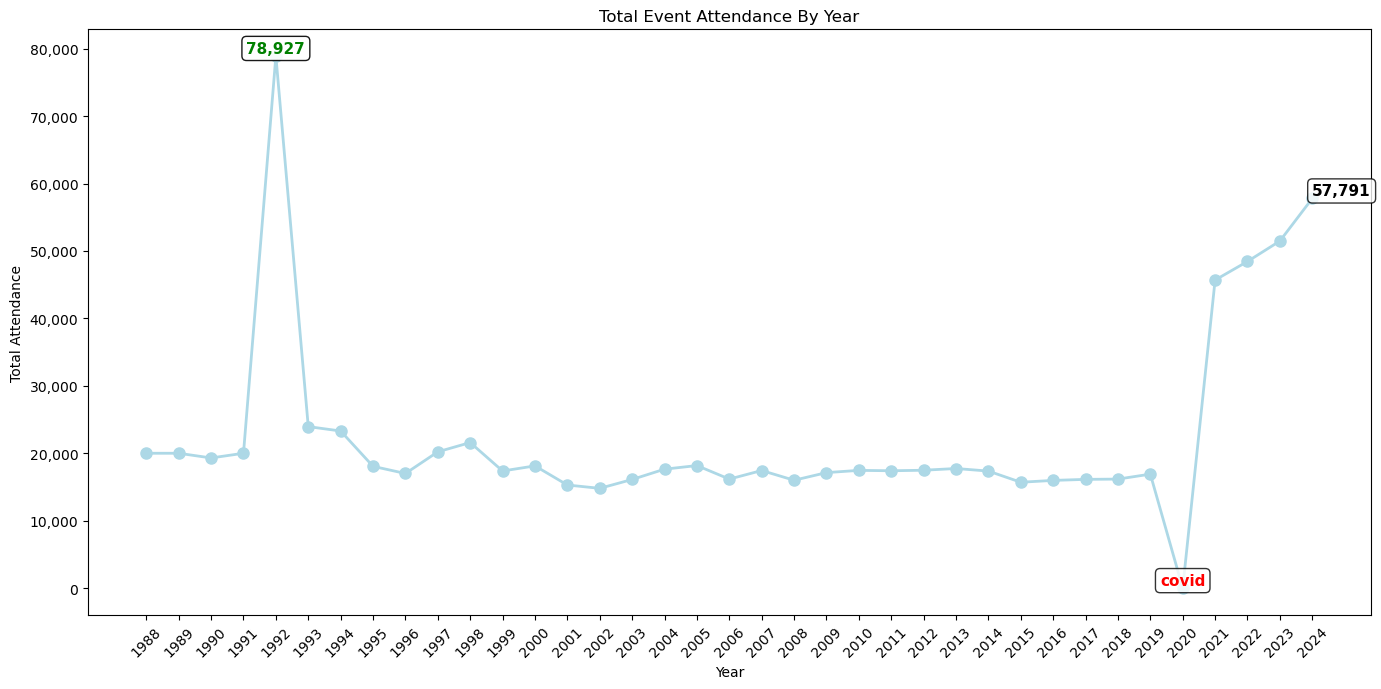

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
events = pd.read_csv('report_event_metrics.csv')

# Remove future events (where event_date is missing)
events = events[events['event_date'].notnull()]

# Aggregate attendance by year
attendance_by_year = events.groupby('event_year')['event_attendance'].sum().reset_index()

# Sort by year in ascending order
attendance_by_year = attendance_by_year.sort_values('event_year')

plt.figure(figsize=(14, 7))

# Plot line and nodes (markers)
plt.plot(
    attendance_by_year['event_year'],
    attendance_by_year['event_attendance'],
    color='lightblue',
    marker='o',
    linewidth=2,
    markersize=8
)

plt.title('Total Event Attendance By Year')
plt.xlabel('Year')
plt.ylabel('Total Attendance')
plt.grid(False)

plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{int(x):,}')
)
plt.xticks(attendance_by_year['event_year'], rotation=45)

# Label the most recent node (attendance value with comma)
most_recent_year = attendance_by_year.iloc[-1]['event_year']
most_recent_attendance = attendance_by_year.iloc[-1]['event_attendance']
plt.text(
    most_recent_year,
    most_recent_attendance,
    f'{int(most_recent_attendance):,}',
    ha='left', va='bottom', fontsize=11, fontweight='bold', color='black',
    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round')
)

# Label the highest attendance node (green)
idx_max = attendance_by_year['event_attendance'].idxmax()
max_year = attendance_by_year.loc[idx_max, 'event_year']
max_attendance = attendance_by_year.loc[idx_max, 'event_attendance']
plt.text(
    max_year,
    max_attendance,
    f'{int(max_attendance):,}',
    ha='center', va='bottom', fontsize=11, fontweight='bold', color='green',
    bbox=dict(facecolor='white', alpha=0.9, boxstyle='round')
)

# Label the lowest attendance node "covid" (red)
idx_min = attendance_by_year['event_attendance'].idxmin()
min_year = attendance_by_year.loc[idx_min, 'event_year']
min_attendance = attendance_by_year.loc[idx_min, 'event_attendance']
plt.text(
    min_year,
    min_attendance,
    'covid',
    ha='center', va='bottom', fontsize=11, fontweight='bold', color='red',
    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round')
)

plt.tight_layout()
plt.savefig('total_event_attendance_by_year.png', dpi=250, bbox_inches='tight')
plt.show()


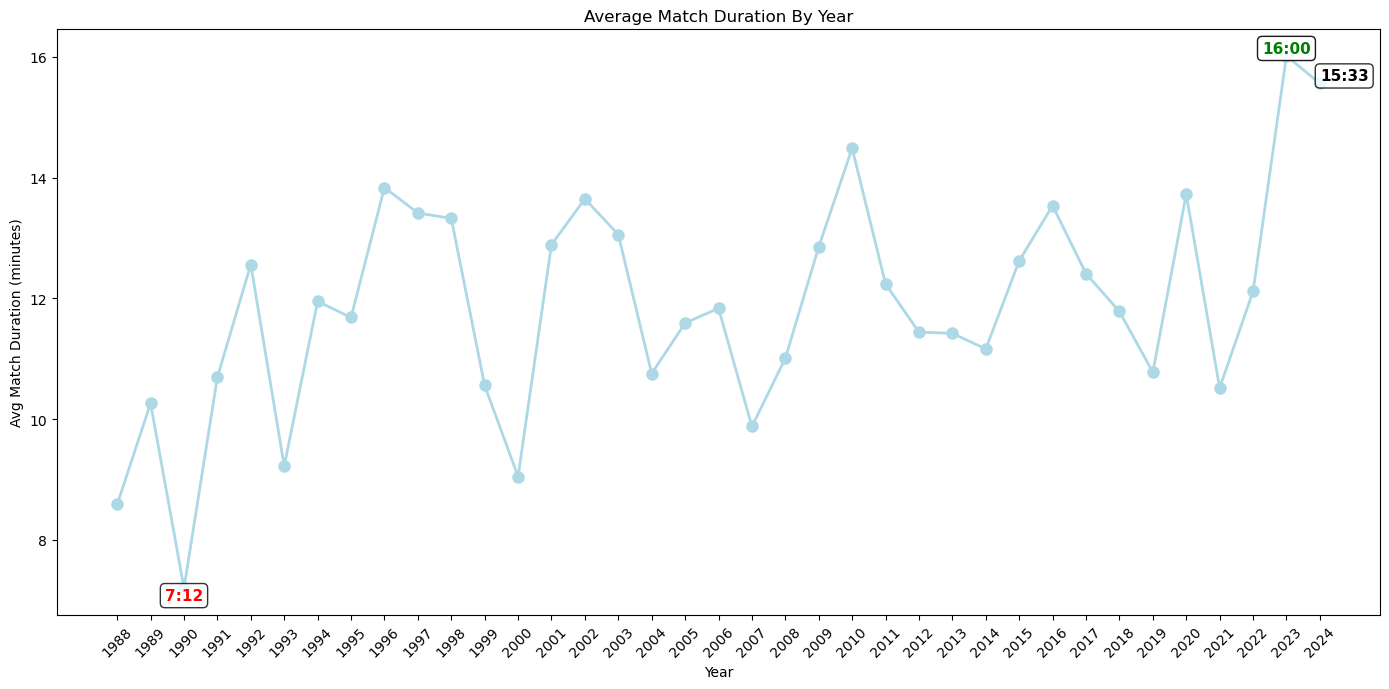

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data
matches = pd.read_csv('report_match_metrics.csv')
matches = matches[matches['event_date'].notnull()]

avg_duration_by_year = matches.groupby('event_year')['match_duration_seconds'].mean().reset_index()
avg_duration_by_year = avg_duration_by_year.sort_values('event_year')

def seconds_to_mmss(secs):
    mins = int(secs) // 60
    sec = int(secs) % 60
    return f"{mins}:{sec:02d}"

plt.figure(figsize=(14, 7))
plt.plot(
    avg_duration_by_year['event_year'],
    avg_duration_by_year['match_duration_seconds'] / 60,
    color='lightblue',
    marker='o',
    linewidth=2,
    markersize=8
)
plt.title('Average Match Duration By Year')
plt.xlabel('Year')
plt.ylabel('Avg Match Duration (minutes)')
plt.grid(False)
plt.xticks(avg_duration_by_year['event_year'], rotation=45)
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{int(x)}')
)

# Annotate most recent year (black)
last_year = avg_duration_by_year.iloc[-1]['event_year']
last_secs = avg_duration_by_year.iloc[-1]['match_duration_seconds']
plt.text(
    last_year,
    last_secs / 60,
    seconds_to_mmss(last_secs),
    ha='left', va='bottom', fontsize=11, fontweight='bold', color='black',
    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round')
)

# Annotate the highest point (green)
idx_max = avg_duration_by_year['match_duration_seconds'].idxmax()
max_year = avg_duration_by_year.loc[idx_max, 'event_year']
max_secs = avg_duration_by_year.loc[idx_max, 'match_duration_seconds']
if max_year != last_year:
    plt.text(
        max_year,
        max_secs / 60,
        seconds_to_mmss(max_secs),
        ha='center', va='bottom', fontsize=11, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round')
    )

# Annotate the lowest point (red)
idx_min = avg_duration_by_year['match_duration_seconds'].idxmin()
min_year = avg_duration_by_year.loc[idx_min, 'event_year']
min_secs = avg_duration_by_year.loc[idx_min, 'match_duration_seconds']
if min_year != last_year and min_year != max_year:
    plt.text(
        min_year,
        min_secs / 60,
        seconds_to_mmss(min_secs),
        ha='center', va='top', fontsize=11, fontweight='bold', color='red',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round')
    )

plt.tight_layout()
plt.savefig('avg_match_duration_trend.png', dpi=300)
plt.show()


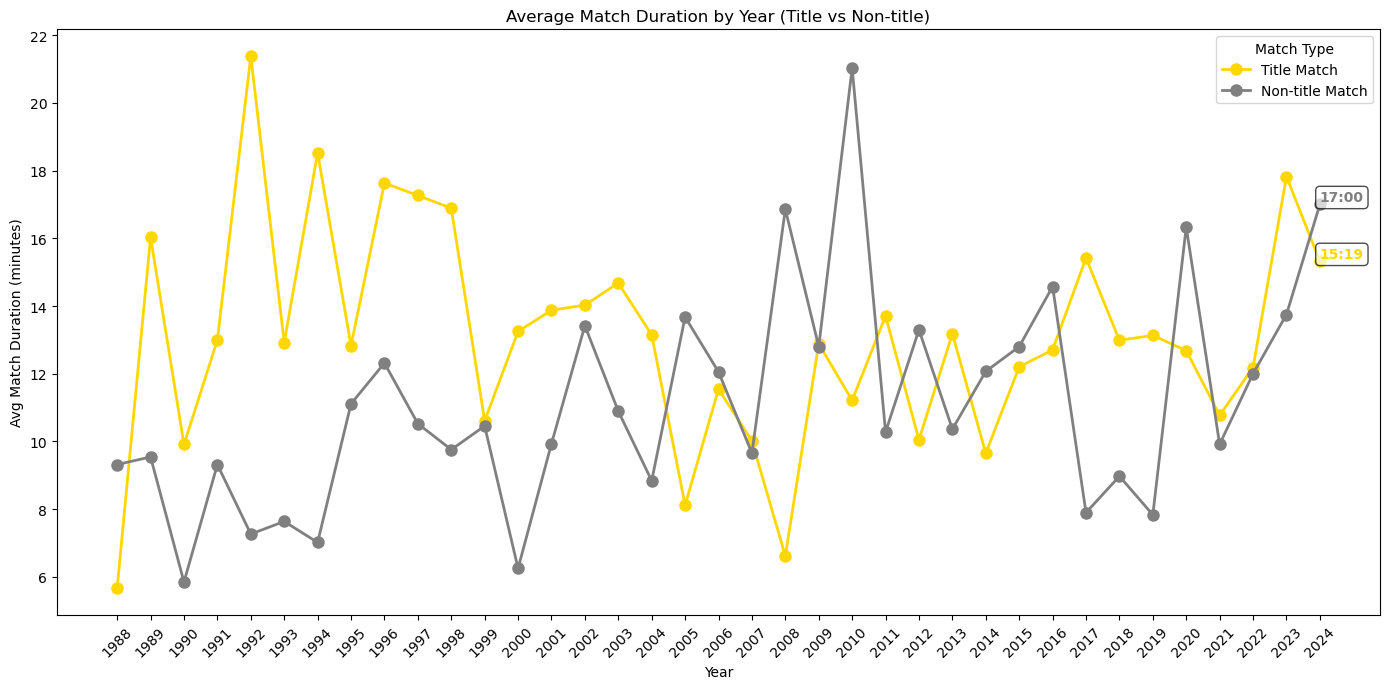

In [127]:
import numpy as np

def seconds_to_mmss(secs):
    mins = int(secs) // 60
    sec = int(secs) % 60
    return f"{mins}:{sec:02d}"

# Group and calculate average by year and championship flag
matches['is_champ'] = matches['is_championship_match'].astype(bool)
avg_by_group = matches.groupby(['event_year', 'is_champ'])['match_duration_seconds'].mean().reset_index()

# Split into title and non-title for easier plotting
years = sorted(matches['event_year'].unique())
title_avgs = avg_by_group[avg_by_group['is_champ']==True].set_index('event_year')['match_duration_seconds']
non_title_avgs = avg_by_group[avg_by_group['is_champ']==False].set_index('event_year')['match_duration_seconds']

plt.figure(figsize=(14, 7))
plt.plot(
    years,
    [title_avgs.get(y, np.nan)/60 for y in years],
    color='#FFD700',  # gold
    marker='o',
    linewidth=2,
    markersize=8,
    label='Title Match'
)
plt.plot(
    years,
    [non_title_avgs.get(y, np.nan)/60 for y in years],
    color='grey',  # grey
    marker='o',
    linewidth=2,
    markersize=8,
    label='Non-title Match'
)

plt.title('Average Match Duration by Year (Title vs Non-title)')
plt.xlabel('Year')
plt.ylabel('Avg Match Duration (minutes)')
plt.grid(False)
plt.xticks(years, rotation=45)
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{int(x)}')
)

# Labels for most recent year points (now in gold/grey)
if len(years) > 0:
    for kind, avgs, c in [('Title Match', title_avgs, '#FFD700'),  # gold
                          ('Non-title Match', non_title_avgs, 'grey')]:  # grey
        last_year = years[-1]
        if not np.isnan(avgs.get(last_year, np.nan)):
            duration = avgs[last_year]
            plt.text(
                last_year,
                duration/60,
                seconds_to_mmss(duration),
                ha='left', va='bottom', fontsize=10, fontweight='bold', color=c,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round')
            )

plt.legend(title='Match Type')
plt.tight_layout()
plt.savefig('avg_match_duration_segmented.png', dpi=300)
plt.show()


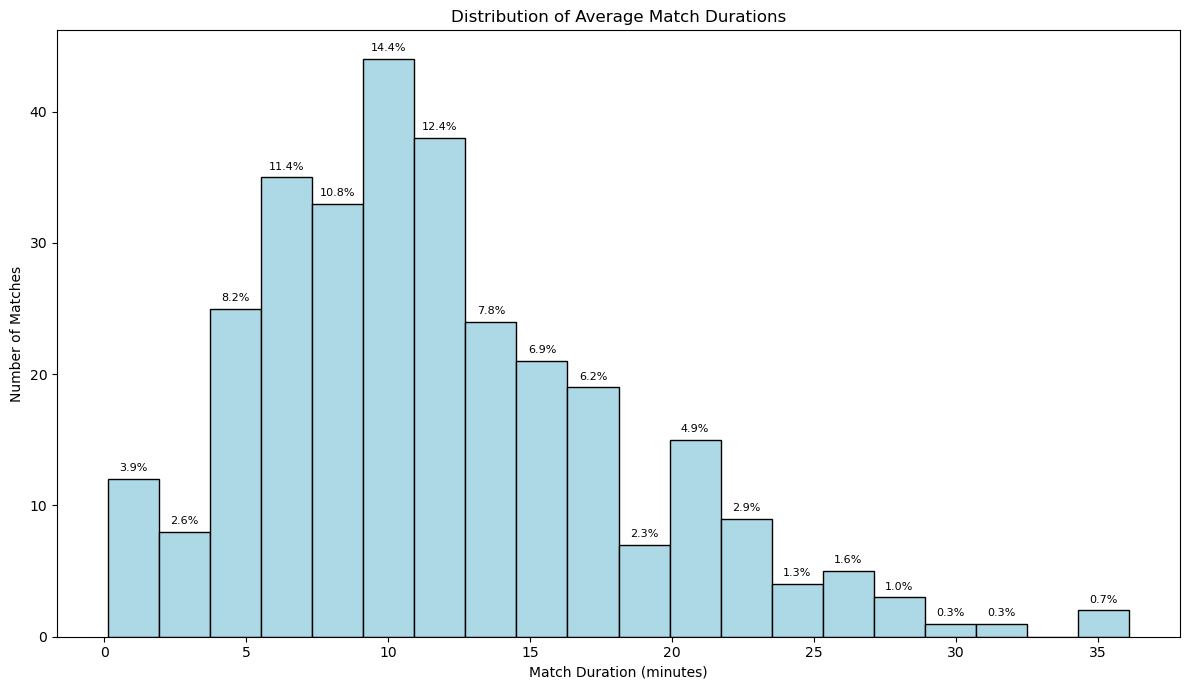

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data
matches = pd.read_csv('report_match_metrics.csv')

# Remove future events (where event_date is missing)
matches = matches[matches['event_date'].notnull()]

# Prepare average durations in minutes
avg_duration_min = matches['match_duration_seconds'] / 60

plt.figure(figsize=(12, 7))
bins = 20
counts, bin_edges, patches = plt.hist(
    avg_duration_min,
    bins=bins,
    color='lightblue',
    edgecolor='black'
)

plt.title('Distribution of Average Match Durations')
plt.xlabel('Match Duration (minutes)')
plt.ylabel('Number of Matches')
plt.grid(False)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

total_matches = counts.sum()

# Add percentage labels above bars
for count, left, right in zip(counts, bin_edges[:-1], bin_edges[1:]):
    if count > 0:
        pct = count / total_matches * 100
        plt.text(
            (left + right) / 2,
            count + max(counts)*0.01,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=8, color='black'
        )

plt.tight_layout()
plt.savefig('avg_match_duration_histogram_labeled.png', dpi=300)
plt.show()
